# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(labels_map=labels)
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
2357960


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
#for i in range(10):
twitter_config._name = "twitter_"# + str(i) + "_"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path, 
                      test_size={"neg": 10000, "pos": 1000},
                      train_size={"neg": 20000, "pos": 20000}, 
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.8858505000000001, 'recall': 0.9153499999999999, 'precision': 0.7182861593475, 'accuracy': 0.777525, 'fpr': 0.3603, 'tnr': 0.6397}
Validate_prediction_by_links: {'auc': 1.0, 'recall': 0.6666666666666666, 'precision': 0.043859649122807015, 'accuracy': 0.9383296460176991, 'fpr': 0.06053873923910025}


In [7]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [8]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [9]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [10]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
3230,880719,0.332886,16,0.667114,1.000000,16,1,1,1,1
2289,352725,0.257328,13,0.742672,1.000000,13,1,1,2,2
3595,2104351,0.191224,13,0.808776,1.000000,13,1,1,3,3
3282,955631,0.505322,18,0.494678,0.944444,17,0,0,3,4
2664,496918,0.372083,12,0.627917,0.916667,11,1,1,4,5
1769,215410,0.404369,12,0.595631,0.833333,10,1,1,5,6
1770,215624,0.425179,15,0.574821,0.800000,12,1,1,6,7
3488,1455795,0.313917,24,0.686083,0.791667,19,1,1,7,8
3564,1886070,0.440589,13,0.559411,0.769231,10,1,0,7,9
2665,496919,0.437207,16,0.562793,0.750000,12,1,1,8,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [11]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [12]:
df[["k", "p@k"]].head(10)

,k,p@k
3230,1,1.000000
2289,2,1.000000
3595,3,1.000000
3282,4,0.750000
2664,5,0.800000
1769,6,0.833333
1770,7,0.857143
3488,8,0.875000
3564,9,0.777778
2665,10,0.800000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

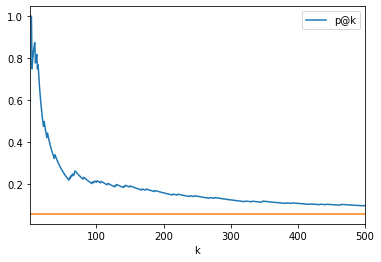

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))

In [14]:
twitter_config._name = "tw"# + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_isolation_forest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 10000, "pos": 1000},
                        training_size={"neg": 20000, "pos": 20000}, 
                        meta_data_cols=meta_data_cols)

Isolation Forest Set.
Setting training and test sets
Existing files were loaded.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.8743437249999999, 'recall': 0.9117000000000001, 'precision': 0.7042849395716528, 'accuracy': 0.7643249999999999, 'fpr': 0.38305000000000006, 'tnr': 0.61695}
